In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
import cv2
import tensorflow as tf
import pickle

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D ,AveragePooling2D, Flatten, Dropout
from keras.layers.core import Dense
from keras.optimizers import RMSprop,Adam,SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [60]:
os.getcwd()

'/content'

In [0]:
handle_train=zipfile.ZipFile(r'/content/Train.zip')
handle_train.extractall('/content/train')
handle_train.close()
handle_test=zipfile.ZipFile(r'/content/Test.zip')
handle_test.extractall('/content/test')
handle_test.close()

In [0]:
train_images=os.listdir('/content/train/Train/')
test_images = os.listdir('/content/test/Test')

filepath_train = '/content/train/Train/'
filepath_test = '/content/test/Test/' 

In [63]:
df_train = pd.read_csv('/content/train.csv')
df_train.head(10)

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
5,6283.jpg,MIDDLE
6,23495.jpg,YOUNG
7,7100.jpg,YOUNG
8,6028.jpg,YOUNG
9,22617.jpg,OLD


In [64]:
sample_submn = pd.read_csv('/content/sample_submission_sDO3m7O.csv')
sample_submn.head()

,Class,ID
0,MIDDLE,25321.jpg
1,MIDDLE,989.jpg
2,MIDDLE,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg


In [0]:

images=[]
labels=[]

for index, row in df_train.iterrows():
  image=cv2.imread(filepath_train+row['ID'])
  image=cv2.resize(image , (64,64))
  images.append(image)
  labels.append(row['Class'])
  #print(row['ID'])


In [0]:
images_test=[]
outputs=[]

for index,row in sample_submn.iterrows():
  image=cv2.imread(filepath_test+row['ID'])
  image=cv2.resize(image , (64,64))
  images_test.append(image) 
  outputs.append(image)

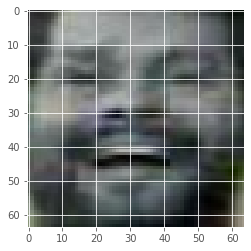

In [67]:
plt.imshow(images[0])

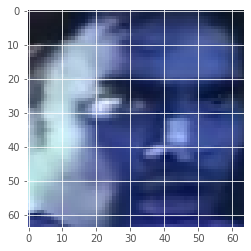

In [68]:
plt.imshow(images[1])

In [69]:
df_train.tail()

,ID,Class
19901,2482.jpg,MIDDLE
19902,20085.jpg,YOUNG
19903,19663.jpg,MIDDLE
19904,10132.jpg,MIDDLE
19905,9896.jpg,MIDDLE


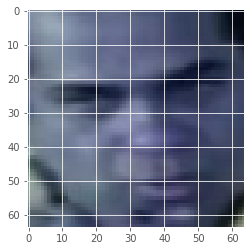

In [70]:
plt.imshow(images[-1])

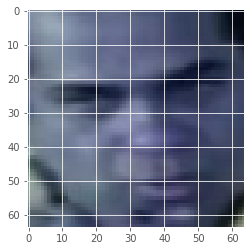

In [71]:
plt.imshow(images[19905])

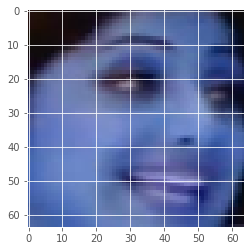

In [72]:
plt.imshow(images[19904])

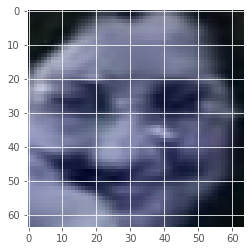

In [73]:
plt.imshow(images_test[0])

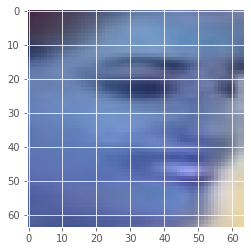

In [74]:
plt.imshow(images_test[-1])

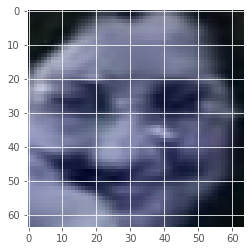

In [75]:
plt.imshow(outputs[0])

In [0]:
images = np.array(images, dtype="float") / 255.0
images_test = np.array(images_test, dtype="float") / 255.0
labels = np.array(labels)

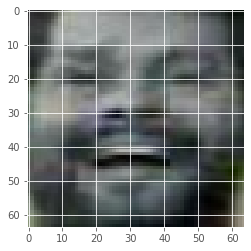

In [77]:
plt.imshow(images[0])

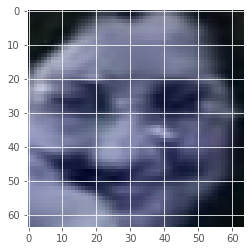

In [78]:
plt.imshow(images_test[0])

In [0]:
(trainX, testX, trainY, testY) = train_test_split(images,labels, test_size=0.20, random_state=42)

In [80]:
print(type(trainX))
print(trainX.shape)
print(type(trainY))
print(trainY.shape)
print(type(testX))
print(testX.shape)
print(type(testY))
print(testY.shape)

<class 'numpy.ndarray'>
(15924, 64, 64, 3)
<class 'numpy.ndarray'>
(15924,)
<class 'numpy.ndarray'>
(3982, 64, 64, 3)
<class 'numpy.ndarray'>
(3982,)


In [0]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [82]:
lb.classes_

array(['MIDDLE', 'OLD', 'YOUNG'], dtype='<U6')

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = "same", activation ='relu', input_shape = (64,64,3)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(3,activation="softmax"))


In [0]:
INIT_LR = 0.01 
EPOCHS = 75
BS = 32

opt=SGD(lr=INIT_LR)

model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])

In [0]:
aug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.1,horizontal_flip=True, fill_mode="nearest")

In [86]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,epochs=EPOCHS)

Epoch 1/75
497/497 [==============================] - 21s 43ms/step - loss: 1.1300 - accuracy: 0.5244 - val_loss: 0.8897 - val_accuracy: 0.6042
Epoch 2/75
497/497 [==============================] - 20s 41ms/step - loss: 0.8483 - accuracy: 0.6153 - val_loss: 0.7915 - val_accuracy: 0.6502
Epoch 3/75
497/497 [==============================] - 20s 41ms/step - loss: 0.8035 - accuracy: 0.6414 - val_loss: 0.8015 - val_accuracy: 0.6444
Epoch 4/75
497/497 [==============================] - 20s 40ms/step - loss: 0.7838 - accuracy: 0.6511 - val_loss: 0.7181 - val_accuracy: 0.6919
Epoch 5/75
497/497 [==============================] - 20s 40ms/step - loss: 0.7594 - accuracy: 0.6637 - val_loss: 0.7165 - val_accuracy: 0.6871
Epoch 6/75
497/497 [==============================] - 20s 40ms/step - loss: 0.7467 - accuracy: 0.6720 - val_loss: 0.6664 - val_accuracy: 0.7170
Epoch 7/75
497/497 [==============================] - 20s 40ms/step - loss: 0.7262 - accuracy: 0.6834 - val_loss: 0.6508 - val_accuracy:

In [87]:
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))

              precision    recall  f1-score   support

      MIDDLE       0.84      0.85      0.85      2181
         OLD       0.82      0.55      0.66       471
       YOUNG       0.78      0.86      0.82      1330

    accuracy                           0.82      3982
   macro avg       0.81      0.75      0.77      3982
weighted avg       0.82      0.82      0.81      3982



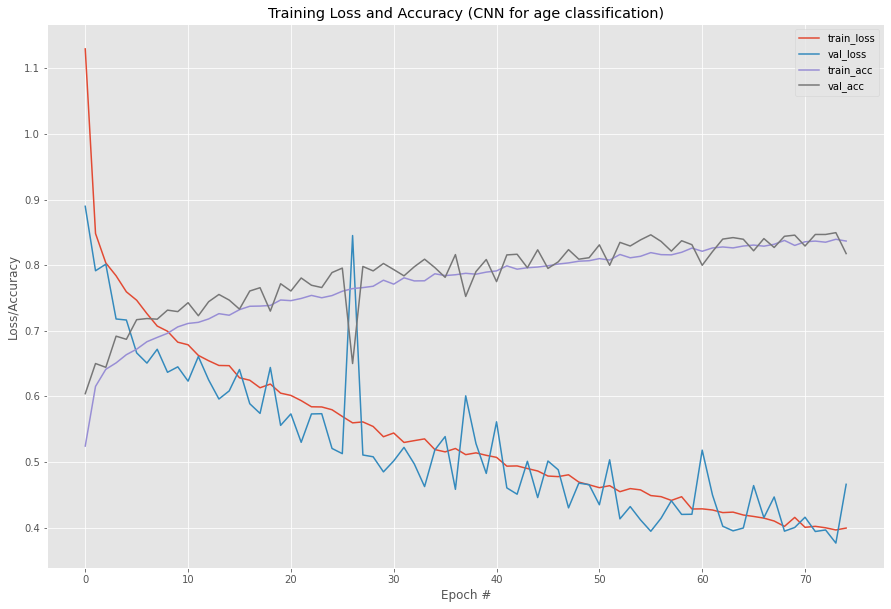

In [119]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (CNN for age classification)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [89]:
pred = model.predict(images_test)
pred

array([[7.77087033e-01, 5.58711356e-03, 2.17325762e-01],
       [1.20589067e-03, 5.07486911e-05, 9.98743355e-01],
       [7.40877092e-02, 9.43176169e-03, 9.16480541e-01],
       ...,
       [8.61440957e-01, 3.51081602e-02, 1.03450894e-01],
       [8.41943681e-01, 3.74843664e-02, 1.20571934e-01],
       [3.92876081e-02, 1.77192487e-04, 9.60535169e-01]], dtype=float32)

In [90]:
i = pred.argmax(axis=1)
i

array([0, 2, 2, ..., 0, 0, 2])

In [91]:
#Going for second test example 
i1 = pred.argmax(axis=1)[1]
i1

2

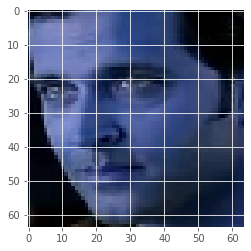

In [92]:
plt.imshow(images_test[1])

In [93]:
vals = np.amax(pred, axis=1)
vals

array([0.77708703, 0.99874336, 0.91648054, ..., 0.86144096, 0.8419437 ,
       0.96053517], dtype=float32)

In [94]:
#going for second test example
val1 = vals[1]
val1

0.99874336

In [95]:
#second test example
perc_val1 = val1*100
perc_val1 = perc_val1.round(2)
perc_val1

99.87

In [0]:
from google.colab.patches import cv2_imshow

In [97]:
label1 = lb.classes_[i1]
label1

'YOUNG'

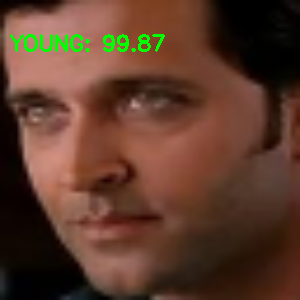

-1

In [98]:
text = label1+": "+str(perc_val1)
#text='.'

outputs[1] = cv2.resize(outputs[1] , (300,300))
cv2.putText(outputs[1], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[1])
cv2.waitKey(0)

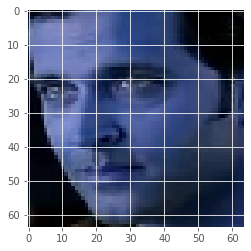

In [99]:
plt.imshow(images_test[1])

In [100]:
output_labels = lb.classes_[i]
output_labels

array(['MIDDLE', 'YOUNG', 'YOUNG', ..., 'MIDDLE', 'MIDDLE', 'YOUNG'],
      dtype='<U6')

In [101]:
submission = pd.DataFrame({'Class':output_labels,'ID':sample_submn['ID']})
submission

,Class,ID
0,MIDDLE,25321.jpg
1,YOUNG,989.jpg
2,YOUNG,19277.jpg
3,MIDDLE,13093.jpg
4,MIDDLE,5367.jpg
...,...,...
6631,MIDDLE,1876.jpg
6632,MIDDLE,14940.jpg
6633,MIDDLE,3638.jpg
6634,MIDDLE,376.jpg


In [0]:
#submission.to_csv('submission3_age_classif.csv',index=False)

In [0]:
#from google.colab import files
#files.download("submission3_age_classif.csv")

In [104]:
#Going for fourth test example 
i3 = pred.argmax(axis=1)[3]
i3

0

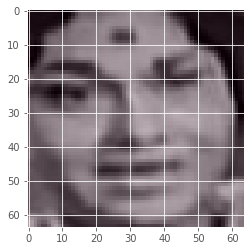

In [105]:
plt.imshow(images_test[3])

In [106]:
val3 = vals[3]
val3

0.7920847

In [107]:
#second test example
perc_val3 = val3*100
perc_val3 = perc_val3.round(2)
perc_val3

79.21

In [108]:
label3 = lb.classes_[i3]
label3

'MIDDLE'

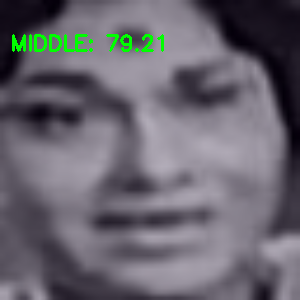

-1

In [109]:
text = label3+": "+str(perc_val3)
#text='.'

outputs[3] = cv2.resize(outputs[3] , (300,300))
cv2.putText(outputs[3], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[3])
cv2.waitKey(0)

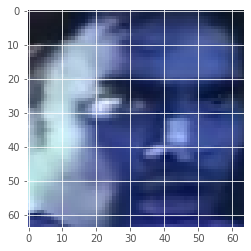

In [110]:
plt.imshow(images[1])

In [111]:
#Going for 6634 test example 
i6631 = pred.argmax(axis=1)[6631]
i6631

0

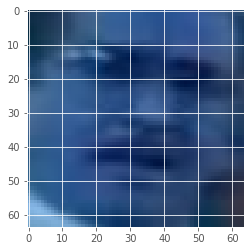

In [112]:
plt.imshow(images_test[6631])

In [113]:
val6631 = vals[6631]
val6631

0.6957967

In [114]:
#second test example
perc_val6631 = val6631*100
perc_val6631 = perc_val6631.round(2)
perc_val6631

69.58

In [115]:
label6631 = lb.classes_[i6631]
label6631

'MIDDLE'

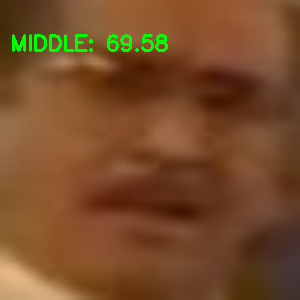

-1

In [116]:
text = label6631+": "+str(perc_val6631)
#text='.'

outputs[6631] = cv2.resize(outputs[6631] , (300,300))
cv2.putText(outputs[6631], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[6631])
cv2.waitKey(0)

In [137]:
sample_submn[sample_submn['ID'] == '2456.jpg']

,Class,ID
3533,MIDDLE,2456.jpg


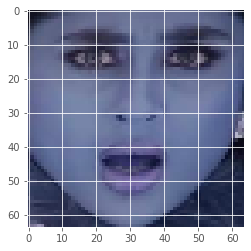

In [138]:
plt.imshow(images_test[3533])

In [139]:
#Going for second test example 
i3533 = pred.argmax(axis=1)[3533]
i3533

2

In [140]:
val3533 = vals[3533]
val3533

0.9966258

In [141]:
perc_val3533 = val3533*100
perc_val3533 = perc_val3533.round(2)
perc_val3533

99.66

In [142]:
label3533 = lb.classes_[i3533]
label3533

'YOUNG'

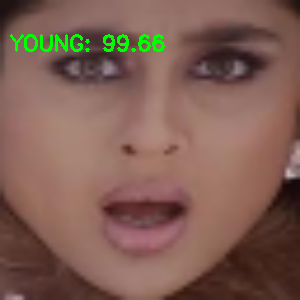

-1

In [143]:
text = label3533+": "+str(perc_val3533)
#text='.'

outputs[3533] = cv2.resize(outputs[3533] , (300,300))
cv2.putText(outputs[3533], text , (10,50),  cv2.FONT_HERSHEY_SIMPLEX, 0.7 ,(0, 255, 0), 2)

# show the output image

cv2_imshow(outputs[3533])
cv2.waitKey(0)

In [0]:
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)

# serialize weights to HDF5
#model.save_weights("model.h5")

In [0]:
#from google.colab import files
#files.download("model.h5")

In [0]:
#from google.colab import files
#files.download("model.json")